# Program Header

In [18]:
import pandas as pd
import numpy as np
import autoreload
import os
import sys
import jellyfish
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [19]:
data_root = initialize_data_root("AY")

# Table of contents
1. [Import](#Import)
2. [Merge](#Merge)
3. [Clean](#Clean)
4. [Reshape](#Reshape)
5. [Save](#Save)

## Import <a name="Import"></a>

In [20]:
raw_sec_data = pd.read_csv(data_root+'02-build/clean/2019q3/sec_data_long.csv')
raw_tag_map = pd.read_csv(data_root+'02-build/clean/2019q3/tag_map.csv')
raw_cik_ticker_map = pd.read_csv(data_root+'02-build/clean/cik_ticker_map.csv')

In [21]:
raw_sec_data.columns

Index(['adsh', 'tag', 'version', 'coreg', 'ddate', 'qtrs', 'uom', 'value',
       'no_coreg', 'no_value', 'cik', 'company_name', 'sic', 'country',
       'period', 'form', 'fye', 'filed', 'accepted', 'instance', 'doc',
       'dyrqt', 'pyrqt'],
      dtype='object')

In [22]:
raw_tag_map.columns

Index(['tag', 'clean_tag'], dtype='object')

In [23]:
raw_cik_ticker_map.columns

Index(['ticker', 'cik'], dtype='object')

## Merge <a name="Merge"></a>

In [24]:
sec_data = raw_sec_data.merge(raw_tag_map, on = ['tag'])\
    .merge(raw_cik_ticker_map, on = ['cik'])

The goal is to get our data to the `adsh`, `dyrqt` level and use the `clean_tag`'s as columns, so we can't have duplicate values for the same `adsh-clean_tag-dyrqt`. In case of duplicates, let's keep the maximum value. The idea behind keeping the max is that smaller versions may be older (over 3 months instead of over 4 months) or the smaller groups may be categories of the larger one.

In [25]:
sec_data = sec_data.groupby(['adsh', 'clean_tag', 'filed',
                             'dyrqt', 'company_name', 'ticker',
                             'cik', 'sic', 'country', 'period', 'form'], as_index = False)['value']\
    .max()

## Clean <a name="Clean"></a>

Check that we're unique on the `adsh-dyrqt-cleantag` level

In [26]:
sec_data.groupby(['adsh', 'dyrqt', 'clean_tag'])\
    .nunique()\
    .sort_values('value', ascending = False)\
    .query("value > 1")

,,,adsh,clean_tag,filed,dyrqt,company_name,ticker,cik,sic,country,period,form,value
adsh,dyrqt,clean_tag,,,,,,,,,,,,


We will also create a version that turns the value negative if the phrase "expense" or "liability" is in the raw tag.

#### Text Citation: Data Cleaning, improvement in tag reach

In [27]:
tag_view = sec_data.groupby('clean_tag').nunique()['cik'].sort_values()/len(sec_data.adsh.unique())

In [28]:
tag_view.describe()

count    88.000000
mean      0.501179
std       0.271095
min       0.072524
25%       0.258643
50%       0.481284
75%       0.744931
max       0.979724
Name: cik, dtype: float64

In [29]:
sum(tag_view > 0.7)

26

## Reshape <a name="Reshape"></a>

In [30]:
sec_data.head()

,adsh,clean_tag,filed,dyrqt,company_name,ticker,cik,sic,country,period,form,value
0,0000002178-19-000086,AccountsPayableCurrent,2019-08-07 00:00:00,201902,"ADAMS RESOURCES & ENERGY, INC.",ae,2178,5172.0,US,2019-06-30,10-Q,116983000.0
1,0000002178-19-000086,AccountsReceivableNetCurrent,2019-08-07 00:00:00,201902,"ADAMS RESOURCES & ENERGY, INC.",ae,2178,5172.0,US,2019-06-30,10-Q,74499000.0
2,0000002178-19-000086,AccumulatedDepreciationDepletionAndAmortizatio...,2019-08-07 00:00:00,201902,"ADAMS RESOURCES & ENERGY, INC.",ae,2178,5172.0,US,2019-06-30,10-Q,97640000.0
3,0000002178-19-000086,AdditionalPaidInCapital,2019-08-07 00:00:00,201902,"ADAMS RESOURCES & ENERGY, INC.",ae,2178,5172.0,US,2019-06-30,10-Q,12497000.0
4,0000002178-19-000086,AllowanceForDoubtfulAccountsReceivableCurrent,2019-08-07 00:00:00,201902,"ADAMS RESOURCES & ENERGY, INC.",ae,2178,5172.0,US,2019-06-30,10-Q,117000.0


In [31]:
sec_data_wide = sec_data.pivot_table(values = 'value',
                                     index = ['adsh', 'company_name', 'dyrqt', 'filed',
                                              'cik', 'sic', 'ticker', 'country', 'period'],
                                    columns = 'clean_tag')\
    .reset_index()

In [32]:
percent_missing = sec_data_wide.isnull().sum() * 100 / len(sec_data_wide)
missing_value_df = pd.DataFrame({'column_name': sec_data_wide.columns,
                                 'percent_missing': percent_missing}).sort_values('percent_missing', ascending = True)

In [33]:
percent_missing_by_company = sec_data_wide.groupby('adsh').apply(lambda x: x.notnull().mean())

#### In-Text Citation: Missing values concentrated in a few columns

In [65]:
percent_missing.sort_values(ascending = False).head()

clean_tag
DueToRelatedPartiesCurrent    92.461658
ProfessionalFees              90.694047
InterestPayableCurrent        87.678711
LiabilitiesNoncurrent         87.470756
DeferredFinanceCostsNet       86.794905
dtype: float64

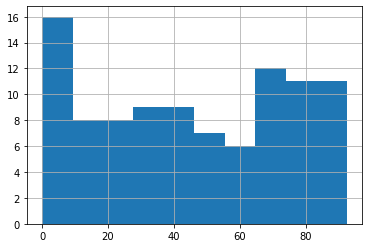

In [63]:
percent_missing.hist()

In [60]:
sum(percent_missing)*0.7

3035.7837275799325

In [59]:
sum(percent_missing.loc[percent_missing > 60])

2898.648297374578

In [35]:
sec_data_wide.fillna(value = 0, inplace = True)

In [36]:
sec_data_wide.loc[sec_data_wide.ticker == 'imci']

clean_tag,adsh,company_name,dyrqt,filed,cik,sic,ticker,country,period,AccountsPayableCurrent,...,ShareBasedCompensation,Short Term Investments,StockIssuedDuringPeriodValue,StockholdersEquity,SubleaseIncome,TotalLiabilities,TreasuryStockShares,TreasuryStockValue,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic
3616,0001654954-19-007941,INFINITE GROUP INC,201704,2019-07-03 00:00:00,884650,7370.0,imci,US,2017-12-31,864931.0,...,0.0,0.0,0.0,-4038564.0,0.0,4620933.0,0.0,0.0,0.0,0.0
3617,0001654954-19-007942,INFINITE GROUP INC,201801,2019-07-03 00:00:00,884650,7370.0,imci,US,2018-03-31,508354.0,...,0.0,0.0,0.0,-4125564.0,0.0,4446753.0,0.0,0.0,29061883.0,0.0
3618,0001654954-19-007943,INFINITE GROUP INC,201802,2019-07-03 00:00:00,884650,7370.0,imci,US,2018-06-30,458249.0,...,0.0,0.0,0.0,-4168564.0,0.0,4337538.0,0.0,0.0,29061883.0,0.0
3619,0001654954-19-007944,INFINITE GROUP INC,201803,2019-07-03 00:00:00,884650,7370.0,imci,US,2018-09-30,352554.0,...,0.0,0.0,0.0,-4152564.0,0.0,4458037.0,0.0,0.0,29061883.0,0.0
3620,0001654954-19-007945,INFINITE GROUP INC,201804,2019-07-03 00:00:00,884650,7370.0,imci,US,2018-12-31,367536.0,...,0.0,0.0,0.0,-4000094.0,0.0,4334197.0,0.0,0.0,0.0,0.0
3621,0001654954-19-007946,INFINITE GROUP INC,201901,2019-07-03 00:00:00,884650,7370.0,imci,US,2019-03-31,286529.0,...,260.0,0.0,0.0,-3964798.0,0.0,4642532.0,0.0,0.0,29061883.0,0.0


In [37]:
most_updated_pyrqt = sec_data_wide.groupby('cik', as_index = False)['dyrqt'].max()
sec_data_wide = sec_data_wide.merge(most_updated_pyrqt, on = ['cik', 'dyrqt'])

In [38]:
sec_data_wide.loc[sec_data_wide.ticker == 'imci']

clean_tag,adsh,company_name,dyrqt,filed,cik,sic,ticker,country,period,AccountsPayableCurrent,...,ShareBasedCompensation,Short Term Investments,StockIssuedDuringPeriodValue,StockholdersEquity,SubleaseIncome,TotalLiabilities,TreasuryStockShares,TreasuryStockValue,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic
3560,0001654954-19-007946,INFINITE GROUP INC,201901,2019-07-03 00:00:00,884650,7370.0,imci,US,2019-03-31,286529.0,...,260.0,0.0,0.0,-3964798.0,0.0,4642532.0,0.0,0.0,29061883.0,0.0


In [39]:
# Try fancyimpute
# X_filled_nnm = NuclearNormMinimization().fit_transform(sec_data_wide)

## Save <a name="Save"></a>
Create CSV versions in build/raw

In [67]:
sec_data_wide.to_csv(data_root+'02-build/clean/2019q3/sec_data_wide.csv')